<a href="https://colab.research.google.com/github/ljrn8/QuickNotebooks/blob/main/blood_cells.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np 
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# import cv2 # opencv
import matplotlib.pyplot as plt

In [ ]:
!tree /kaggle/input --filelimit 10

/kaggle/input
└── blood-cells
    ├── dataset-master
    │   └── dataset-master
    │       ├── Annotations [343 entries exceeds filelimit, not opening dir]
    │       ├── JPEGImages [366 entries exceeds filelimit, not opening dir]
    │       └── labels.csv
    └── dataset2-master
        └── dataset2-master
            ├── images
            │   ├── TEST
            │   │   ├── EOSINOPHIL [623 entries exceeds filelimit, not opening dir]
            │   │   ├── LYMPHOCYTE [620 entries exceeds filelimit, not opening dir]
            │   │   ├── MONOCYTE [620 entries exceeds filelimit, not opening dir]
            │   │   └── NEUTROPHIL [624 entries exceeds filelimit, not opening dir]
            │   ├── TEST_SIMPLE
            │   │   ├── EOSINOPHIL [13 entries exceeds filelimit, not opening dir]
            │   │   ├── LYMPHOCYTE
            │   │   │   ├── _0_3975.jpeg
            │   │   │   ├── _1_4044.jpeg
            │   │   │   ├── _2_6981.jpeg
            │   │   │   ├── _3_75

In [ ]:
base_dir = '/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/'

what does the data look like?

sample image shape:  (240, 320, 3)


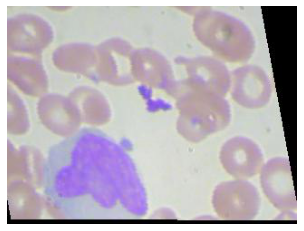

In [ ]:
fname = os.listdir(base_dir + 'TRAIN/MONOCYTE/')[0]
sample_image = plt.imread(base_dir + 'TRAIN/MONOCYTE/' + fname)
print('sample image shape: ', sample_image.shape)
plt.imshow(sample_image)
plt.axis('off')
plt.show()

MONOCYTE


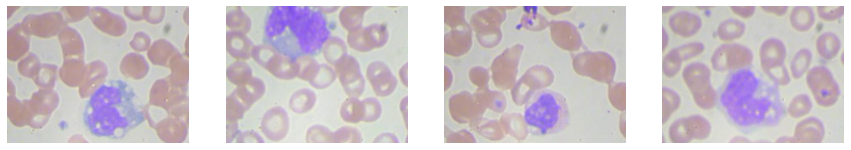

LYMPHOCYTE


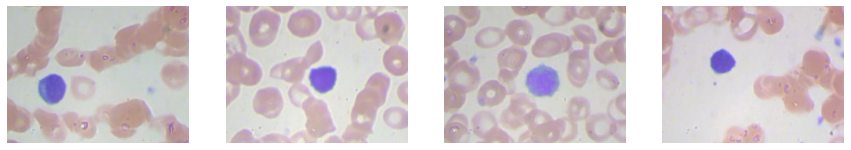

EOSINOPHIL


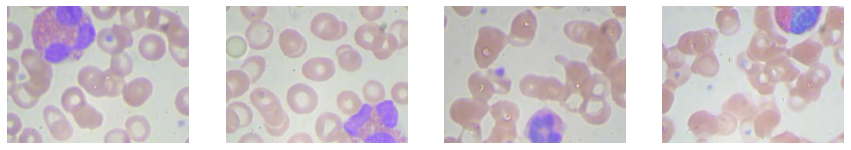

NEUTROPHIL


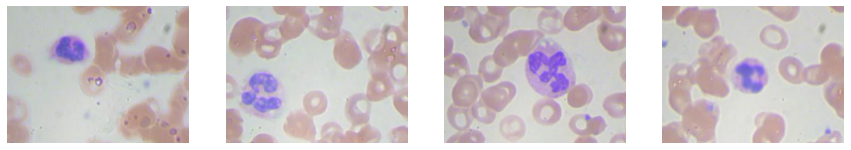

In [ ]:
def peak(path):
    ''' looks at the first 4 images '''
    fig, axs = plt.subplots(1,4, figsize=(15,7))
    for count, (ax, filename) in enumerate(zip(axs, os.scandir(path))):
        image = plt.imread(filename.path)
        ax.imshow(image)
        ax.axis('off')
        if count == 4:
            break
    plt.show()

subcats = ['MONOCYTE', 'LYMPHOCYTE', 'EOSINOPHIL', 'NEUTROPHIL']
for subcat in subcats:
    print(subcat)
    peak(base_dir + 'TEST_SIMPLE/' + subcat + '/')   

In [ ]:
batch = 32

test_ds = tf.keras.utils.image_dataset_from_directory(
    base_dir + 'TEST/', seed=0, batch_size=batch
)
valid_ds = tf.keras.utils.image_dataset_from_directory(
    base_dir + 'TRAIN/', seed=0, batch_size=batch,
    validation_split=0.2, subset="validation", 
)
train_ds = tf.keras.utils.image_dataset_from_directory(
    base_dir + 'TRAIN/', seed=0, batch_size=batch,
    validation_split=0.2, subset="training", 
)
# ds: full dataset
ds = test_ds.concatenate(train_ds).concatenate(valid_ds)

Found 2487 files belonging to 4 classes.
Found 9957 files belonging to 4 classes.
Using 1991 files for validation.
Found 9957 files belonging to 4 classes.
Using 7966 files for training.


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(240, 320),
  layers.Rescaling(1./255.)
])
ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
            num_parallel_calls=AUTOTUNE)
ds = ds.shuffle(1000).prefetch(buffer_size=AUTOTUNE)

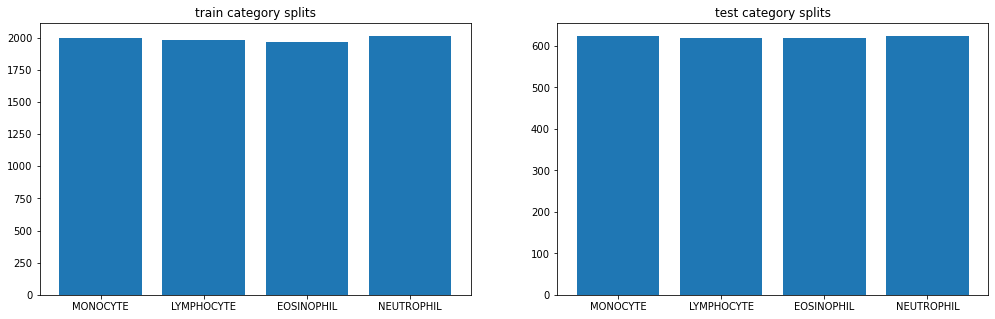

In [ ]:
def plot_categories(ds, categories, ax=plt):
    labels_ds = ds.map(lambda x, y: y)
    labels_np = np.concatenate(list(labels_ds.as_numpy_iterator()))
    uniq, counts = np.unique(labels_np, return_counts=True)
    ax.bar(categories, counts)
    
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 5))
ax1.set_title('train category splits')
plot_categories(train_ds, subcats, ax=ax1)
ax2.set_title('test category splits')
plot_categories(test_ds, subcats, ax=ax2)
plt.show()    

In [ ]:
model = tf.keras.applications.InceptionV3(
    include_top=True,
    weights=None,
    input_shape=[256, 256, 3],
    classes=4,
)
model.compile(
    optimizer=keras.optimizers.Adam(0.01),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [ ]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=4)
history = model.fit(train_ds, epochs=10, callbacks=[early_stopping_cb], validation_data=valid_ds)

Epoch 1/10
  6/249 [..............................] - ETA: 30:44 - loss: 4.3706 - accuracy: 0.2240

KeyboardInterrupt: 

# TODO 
- read in data first
- value counts